In [1]:
#Import libraries
import os
import pydicom
import numpy as np
import keras
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
#Import own utilities
import preproc
import net3d_model as model_3d
import utils
import keraOverlay as overlay
import keras.callbacks as callbacks

/home/yuan/Software/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load data and masks as dicom files
data_dir = '../../../data'                   #Please change the path accordingly before make any changes
normalNames = data_dir + '/GoodData_256auto.txt'
img_dir = data_dir + '/256Auto/images'
msk_dir = data_dir + '/256Auto/masks'

In [3]:
n_slices = 64
size = 64
#model, prediction = model_3d.conv_net(size=size, activation_type="sigmoid", n_slices=n_slices, depth=5, n_base_filters=16)
model, prediction = model_3d.simple_unet(n_slices, size)
#model.summary()
# This visualization might not work depending on how graphviz is installed, but it gives a simple overview of the structure.
#To do: output this image to file or in pop up window
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))
model.compile(loss=overlay.dice_coef_loss, optimizer='adam', metrics=['acc', overlay.dice_coef])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', model_3d.dice_coef])


In [4]:
normal_namelist = []
with open(normalNames) as f:
    content = f.readlines()
    normal_namelist = [x.strip() for x in content] 
#Cross Validation
n_data = 10
k = 10   #Number of folds
n_batch = 1 #Number of batches
data_name_list = normal_namelist[:n_data]

In [5]:

folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(np.array(data_name_list), np.zeros(n_data)))

#callbacks
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=0.003, verbose=0, mode='auto')


for index in range(k):
    print(index+1, "/", k, "fold")
    train_list = [data_name_list[i] for i in folds[index][0]]
    val_list = [data_name_list[i] for i in folds[index][1]]
    #print(train_list, val_list)
    
    history = model.fit_generator(overlay.generate_box_data(img_dir, msk_dir, train_list, batch_size=n_batch, only_valid=True), 
                                  epochs=5, verbose=1, steps_per_epoch=len(train_list)/n_batch,
                                  validation_data=overlay.generate_batch_data(img_dir, msk_dir, val_list, batch_size=1, scaling=4),
                                  validation_steps=len(val_list),
                                  callbacks=[earlystop])


1 / 10 fold
Epoch 1/5
4/9 [============>.................] - ETA: 12s - loss: 0.9279 - acc: 0.6458 - dice_coef: 0.0721

KeyboardInterrupt: 

In [6]:
#Load data
x_list, y_list = utils.load_data(img_dir, msk_dir, data_name_list, sigma_image=0, sigma_mask=0, scaling=4, OPaslist=True)

In [7]:
n_slice = 64
size = 64

index = 2

#data = utils.padImage(x_list[index])
#data_tobox = preproc.to3dpatches(data, )
predictions = model.predict(x_list[index].reshape(1,n_slice,size,size,1), steps=1)

In [8]:
from keras import backend

print(backend.floatx())

#dice = model_3d.dice_coef(predictions[0],x_list[index])
result = predictions[0]
result[result>=0.7] = 1
result[result<0.7] = 0
dice = overlay.dice_coef_loss(y_list[index].reshape(1,64,64,64),result.reshape(1,64,64,64))
#dice = model_3d.dice_coef(backend.cast_to_floatx(y_list[0]).reshape(1,64,64,64),backend.cast_to_floatx(y_list[0]).reshape(1,64,64,64))

#print(predictions[0][slice_index].dtype)
#dice = dice_coef(y_list[index],predictions[0])
print(dice)
#dice = backend.print_tensor(dice*8, message='y_pred = ')
#backend.print_tensor(dice, message='')
#print(dice)
#piece = predictions[0]
#piece = piece[piece > 0.9]
#dice = model_3d.dice_coef(piece,piece)
backend.eval(dice)

float32
Tensor("Mean_1:0", shape=(), dtype=float32)


0.9729002

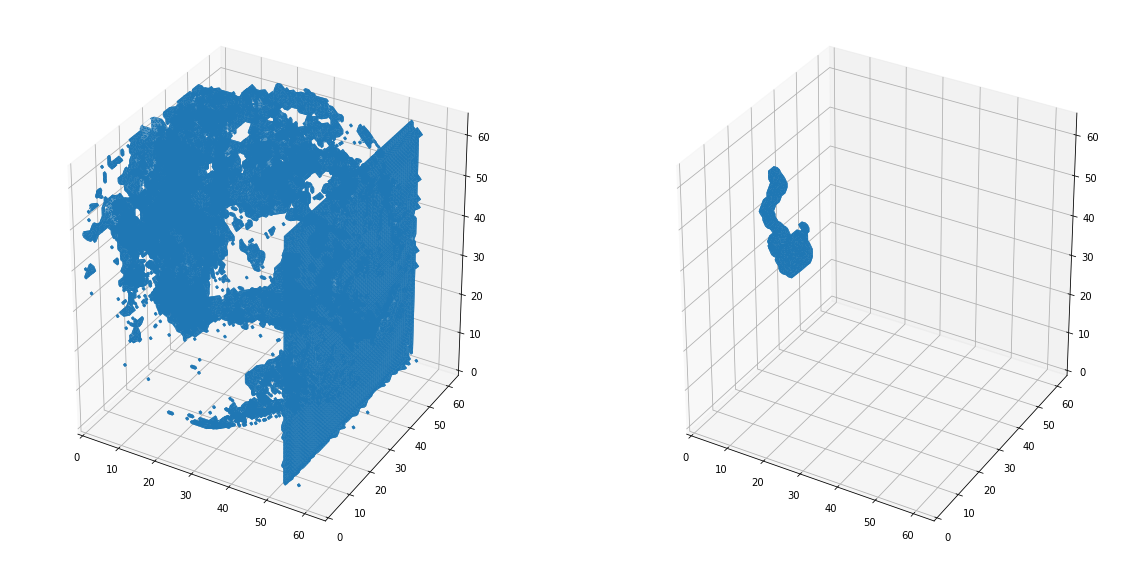

In [10]:
utils.plot_3d(predictions[0].reshape(64,64,64), y_list[index], threshold=0.5, threshold2=0.0)